In [1]:
from processing.preprocessing import BCIDataProcessor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from mne.decoding import CSP

recording_path = '../recordings/recording_imagery1_gel.raw.fif'
window_size = 2
window_overlap = 1
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process()
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[-9.75781955e-18, -7.72448953e-05, -1.30784509e-04, ...,
           5.48346682e-06,  7.00323183e-06,  7.73716556e-06],
         [ 8.89045781e-18, -2.74854834e-05, -4.68128323e-05, ...,
           9.08280425e-06,  8.26464882e-06,  7.95344324e-06],
         [-7.58941521e-18, -2.73413427e-05, -4.62287315e-05, ...,
           1.03290678e-05,  1.10359154e-05,  1.13433084e-05],
         ...,
         [ 1.44740990e-17, -1.20738786e-06, -1.86951054e-06, ...,
           1.21085708e-05,  1.08661758e-05,  8.21043618e-06],
         [-8.45677695e-18, -7.81924180e-06, -1.31377540e-05, ...,
           7.05616209e-06,  6.63435329e-06,  5.38865643e-06],
         [ 5.96311195e-19,  3.25363642e-06,  4.65901998e-06, ...,
           3.15028026e-06,  2.83791594e-06,  2.66301503e-06]],
 
        [[-5.71551646e-07, -1.70043263e-06,  2.48659827e-06, ...,
          -3.36096019e-05, -1.13624546e-05,  9.70437272e-06],
         [ 7.92954737e-07,  2.66120511e-06,  5.92089045e-06, ...,
          -1

In [2]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((112, 8, 500), (112,), (89, 8, 500), (89,), (23, 8, 500), (23,))

Classification accuracy: 0.9055555555555556 / Chance level: 0.5056179775280899


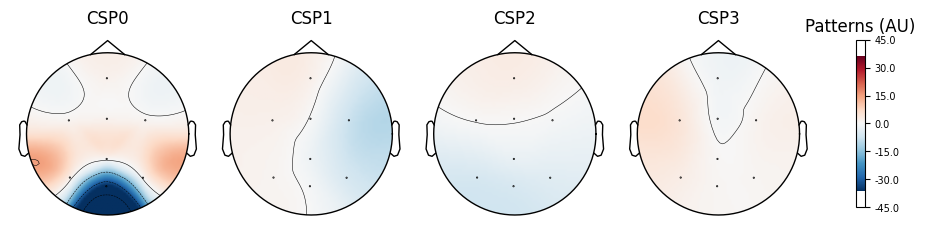

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(X_trainval, y_trainval)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, X_trainval, y_trainval, cv=cv_split, n_jobs=1)

# Printing the results
class_balance = np.mean(y_trainval == "relax")
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(X, y)
csp.plot_patterns(processor.raw.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
plt.show()